In [1]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, tube_kv, solve_network_pressures, plot_pressure_ladder, TubeComponent

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)
    
hp_tank = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 2e5, gas=air, gas_temp=300)
hp_tube_0 = TubeComponent(name='HP Bend 0 - SS-1610-9', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
orifice_0 = FlowComponent(name='Test Orifice', kv=3)
hp_tube_1 = TubeComponent(name='HP Bend 0 - SS-1610-9', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)

hp_tank_node = FluidNode("HP Tank", tank=hp_tank, pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas)
tube0_to_orifice = FluidNode("Tube 0 to Orifice", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
orifice_to_tube1 = FluidNode("Orifice to Tube 1", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

hp_tank_node.connect_nodes([(tube0_to_orifice, hp_tube_0, False)])
tube0_to_orifice.connect_nodes([(hp_tank_node, hp_tube_0, True), (orifice_to_tube1, orifice_0, False)])
orifice_to_tube1.connect_nodes([(tube0_to_orifice, orifice_0, True), (atmosphere_node, hp_tube_1, False)])
atmosphere_node.connect_nodes([(orifice_to_tube1, hp_tube_1, True)])

total_nodes = [hp_tank_node, tube0_to_orifice, orifice_to_tube1, atmosphere_node]

for node in total_nodes:
    if node.tank:
        node.pressure = node.tank.pressure
        node.temperature = node.tank.gas_temp if node.tank.gas is not None else None

        if node.tank.liquid and node.tank.mass_liquid > 0:
            node.fluid = node.tank.liquid
        else:
            node.fluid = node.tank.gas

from tqdm import tqdm
# for _ in tqdm(range(1000)):
solve_network_pressures(total_nodes, 0)

plot_pressure_ladder(total_nodes)


Node 'HP Tank': Pressure=2.00 bar, Fluid=Gas
Node 'Tube 0 to Orifice': Pressure=1.71 bar, Fluid=Gas
-> Tube 'HP Bend 0 - SS-1610-9 from 'HP Tank' is carrying Air at velocity 354.39 m/s
Node 'Orifice to Tube 1': Pressure=1.52 bar, Fluid=Gas
Node 'Atmosphere': Pressure=1.01 bar, Fluid=Gas
-> Tube 'HP Bend 0 - SS-1610-9 from 'Orifice to Tube 1' is carrying Air at velocity 209.41 m/s


In [11]:
print(tube_kv(2e5, 199984, 2.322, 1.8e-5, D=0.01042, L=2, roughness=1.5e-6, bend_ang=0, K_extra=0))

1.0721243742766249


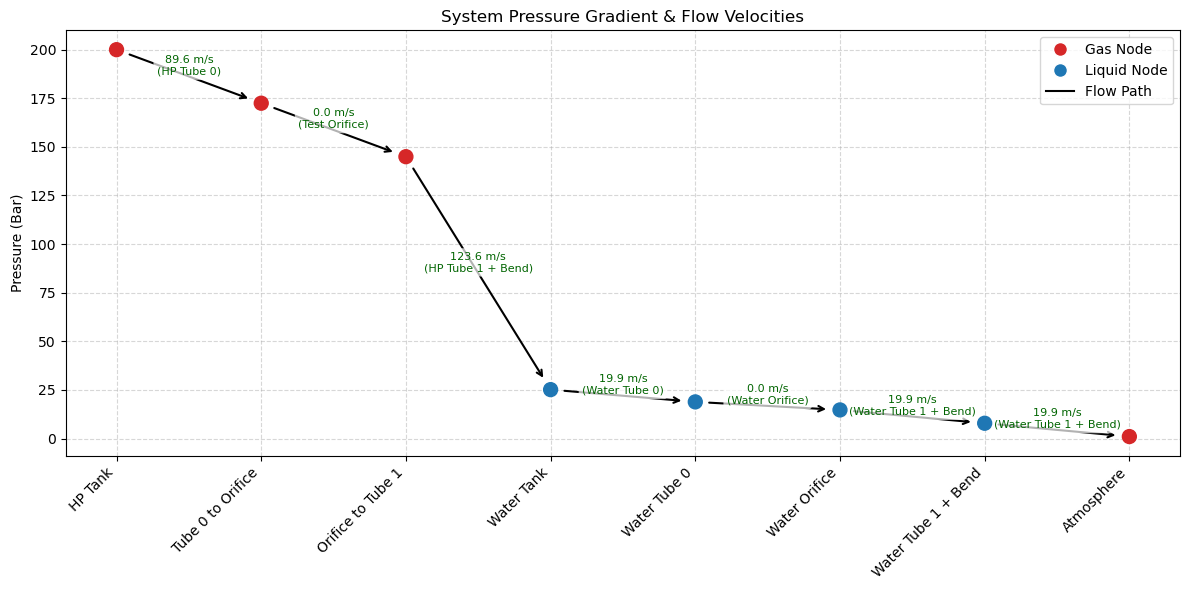

In [14]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, plot_pressure_network, TubeComponent, dae_system, initialize_tanks, timed_valve_kv, regulator_kv

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)
    
hp_tank = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 200e5, gas=air, gas_temp=300)
hp_tube_0 = TubeComponent(name='HP Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
orifice_0 = FlowComponent(name='Test Orifice', kv=3)
hp_tube_1 = TubeComponent(name='HP Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)
water_tank = Tank(name='Water Tank', volume=0.005, mass_liquid=0.004*1000, pressure = 25e5, gas=air, gas_temp=300, liquid=water)
water_tube_0 = TubeComponent(name='Water Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
water_orifice = FlowComponent(name='Water Orifice', kv=3)
water_tube_1= TubeComponent(name='Water Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)

hp_tank_node = FluidNode("HP Tank", tank=hp_tank, pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas)
tube0_to_orifice = FluidNode("Tube 0 to Orifice", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
orifice_to_tube1 = FluidNode("Orifice to Tube 1", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 

water_tank_node = FluidNode("Water Tank", tank=water_tank, pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_0_node = FluidNode("Water Tube 0", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_orifice_node = FluidNode("Water Orifice", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_1_node = FluidNode("Water Tube 1 + Bend", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)

atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

hp_tank_node.connect_nodes([(tube0_to_orifice, hp_tube_0, False)])
tube0_to_orifice.connect_nodes([(hp_tank_node, hp_tube_0, True), (orifice_to_tube1, orifice_0, False)])
orifice_to_tube1.connect_nodes([(tube0_to_orifice, orifice_0, True), (water_tank_node, hp_tube_1, False)])
water_tank_node.connect_nodes([(orifice_to_tube1, hp_tube_1, True), (water_tube_0_node, water_tube_0, False)])
water_tube_0_node.connect_nodes([(water_tank_node, water_tube_0, True), (water_orifice_node, water_orifice, False)])
water_orifice_node.connect_nodes([(water_tube_0_node, water_orifice, True), (water_tube_1_node, water_tube_1, False)])
water_tube_1_node.connect_nodes([(water_orifice_node, water_tube_1, True), (atmosphere_node, water_tube_1, False)])
atmosphere_node.connect_nodes([(water_tube_1_node, water_tube_1, True)])

total_nodes = [hp_tank_node, tube0_to_orifice, orifice_to_tube1, water_tank_node, water_tube_0_node, water_orifice_node, water_tube_1_node, atmosphere_node]
tanks = [hp_tank, water_tank]

initial_masses, initial_temperatures = initialize_tanks(tanks)

# plot_pressure_network(total_nodes)


from scipy.integrate import solve_ivp
import numpy as np


solution = solve_ivp(
    dae_system,
    t_span=(0, 0.0001),
    y0=initial_masses,
    method='RK45',
    rtol=1e-6,
    atol=1e-9,
    args=(total_nodes, tanks),
    # t_eval=np.linspace(0, 0.5, 5)
)

plot_pressure_network(total_nodes)
